In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import torch


from PIL import Image
import torch
from torchvision import models, transforms
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import glob

import faiss

import clip
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Datasets

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from skimage import io, transform
import random

### AID

To Do
- Dataset Details

In [4]:
class AID(Dataset):

    def __init__(self, root_dir):

        self.label_map = {}
        self.info = []
        i = 0
        for root, dirs, files in os.walk(root_dir):
                
            for file in files:
                
                if file.endswith((".jpg", ".tif", ".png", "jpeg")):
                    file_path = os.path.join(root, file)
                    label = root.split('/')[-1]
                    self.info.append((file_path, label.lower()))


                if label.lower() not in self.label_map:
                    self.label_map[label.lower()] = i
                    i += 1

        random.shuffle(self.info)
        self.transform = transform


    def map_labels(self, label):
        return self.label_map[label]





    def __len__(self):
        return len(self.info)


    def __getitem__(self, idx):
        img_path, label = self.info[idx]

        label = self.map_labels(label.lower())

        img = torch.tensor(io.imread(img_path)[:,:,:3], dtype=torch.float32)
        # img = img / 255.
        
        return img, label, img_path

In [5]:
dataset = AID('datasets/AID')
label_map = dataset.label_map

'''
# Parameters
batch_size = 32
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
# Create train and validation splits
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
'''


class_map = {v: k for k, v in label_map.items()}
classes = [v for k,v in class_map.items()]

In [6]:
dataset = AID('datasets/AID')

In [7]:
label_map

{'viaduct': 0,
 'railwaystation': 1,
 'center': 2,
 'farmland': 3,
 'industrial': 4,
 'baseballfield': 5,
 'forest': 6,
 'sparseresidential': 7,
 'beach': 8,
 'port': 9,
 'desert': 10,
 'mountain': 11,
 'commercial': 12,
 'bareland': 13,
 'river': 14,
 'pond': 15,
 'stadium': 16,
 'meadow': 17,
 'school': 18,
 'airport': 19,
 'park': 20,
 'square': 21,
 'storagetanks': 22,
 'playground': 23,
 'parking': 24,
 'church': 25,
 'bridge': 26,
 'resort': 27,
 'denseresidential': 28,
 'mediumresidential': 29}

In [8]:
class_map

{0: 'viaduct',
 1: 'railwaystation',
 2: 'center',
 3: 'farmland',
 4: 'industrial',
 5: 'baseballfield',
 6: 'forest',
 7: 'sparseresidential',
 8: 'beach',
 9: 'port',
 10: 'desert',
 11: 'mountain',
 12: 'commercial',
 13: 'bareland',
 14: 'river',
 15: 'pond',
 16: 'stadium',
 17: 'meadow',
 18: 'school',
 19: 'airport',
 20: 'park',
 21: 'square',
 22: 'storagetanks',
 23: 'playground',
 24: 'parking',
 25: 'church',
 26: 'bridge',
 27: 'resort',
 28: 'denseresidential',
 29: 'mediumresidential'}

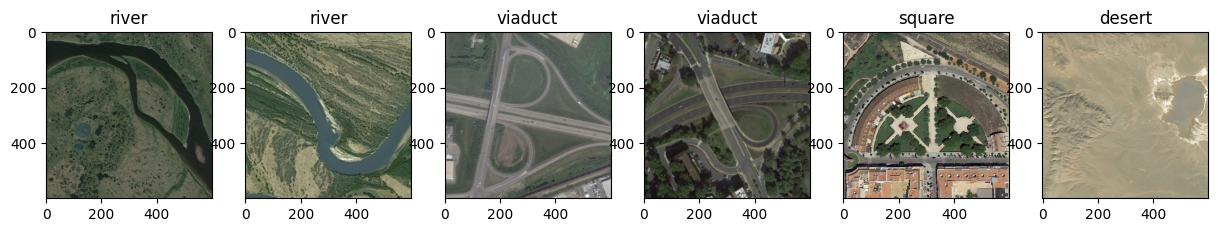

In [9]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(15, 5)) 

for i in range(n):
    img, label, _ = dataset[i]
    label = class_map[label]

    axs[i].imshow(img/255)
    axs[i].set_title(label)

### FAIR1M

In [53]:
class FAIR1M(Dataset):

    def __init__(self, root_dir, transform=None):

        self.label_map = {
            'ship': 0,
            'airplane': 1,
            'neighborhood': 2,
        }

        self.info = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith((".jpg", ".tif", ".png", "jpeg")):
                    file_path = os.path.join(root, file)
                    label = root.split('/')[-1]
                    self.info.append((file_path, label))

        random.shuffle(self.info)
        self.transform = transform

    def map_labels(self, label):
        return self.label_map[label]





    def __len__(self):
        return len(self.info)


    def __getitem__(self, idx):
        img_path, label = self.info[idx]

        label = self.map_labels(label.lower())

        img = io.imread(img_path)[:,:,:3]
        img = img / 255.
        
        return img, label

In [54]:
dataset = FAIR1M('datasets/FAIR1M_partial')


'''
# Parameters
batch_size = 32
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
# Create train and validation splits
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
'''


class_map = {
    0: 'ship',
    1: 'airplane',
    2: 'neighborhood',
}

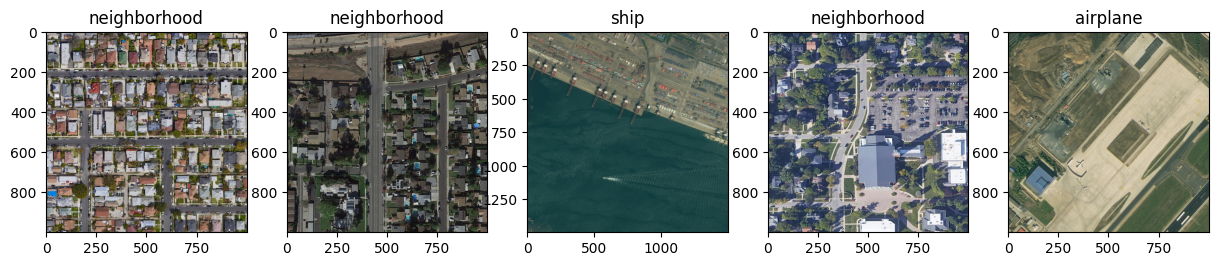

In [55]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5)) 

for i in range(5):
    img, label = dataset[i]
    label = class_map[label]

    axs[i].imshow(img)
    axs[i].set_title(label)

### RESISC45

In [13]:
class RESISC45(Dataset):

    def __init__(self, root_dir, transform=None):

        self.label_map = {
            'ship': 0,
            'airplane': 1,
            'bridge': 2,
        }

        self.info = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith((".jpg", ".tif", ".png", "jpeg")):
                    file_path = os.path.join(root, file)
                    label = root.split('/')[-1]
                    self.info.append((file_path, label))

        random.shuffle(self.info)
        self.transform = transform

    def map_labels(self, label):
        return self.label_map[label]





    def __len__(self):
        return len(self.info)


    def __getitem__(self, idx):
        img_path, label = self.info[idx]

        label = self.map_labels(label.lower())

        img = io.imread(img_path)[:,:,:3]
        img = img / 255.
        
        return img, label

In [14]:
dataset = RESISC45('datasets/RESISC45_partial')

In [15]:
class_map = {
    0: 'ship',
    1: 'airplane',
    2: 'neighborhood',
}

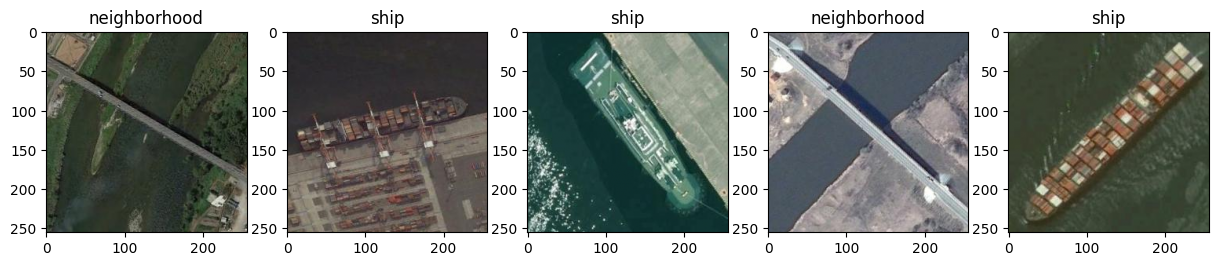

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5)) 

for i in range(5):
    img, label = dataset[i]
    label = class_map[label]

    axs[i].imshow(img)
    axs[i].set_title(label)

### Sentinel-2 ship

In [17]:
class SS2(Dataset):

    def __init__(self, root_dir, transform=None):

        self.label_map = {
            'ship': 0,
            'noship': 1,
        }

        self.info = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith((".jpg", ".tif", ".png", "jpeg")):
                    file_path = os.path.join(root, file)
                    label = root.split('/')[-1]
                    self.info.append((file_path, label))

        random.shuffle(self.info)
        self.transform = transform

    def map_labels(self, label):
        return self.label_map[label]





    def __len__(self):
        return len(self.info)


    def __getitem__(self, idx):
        img_path, label = self.info[idx]

        label = self.map_labels(label.lower())

        img = io.imread(img_path)[:,:,:3]
        img = img / 255.
        
        return img, label

In [18]:
dataset = SS2('datasets/Sentinel2_partial')

In [19]:
class_map = {
    0: 'ship',
    1: 'noship',
}

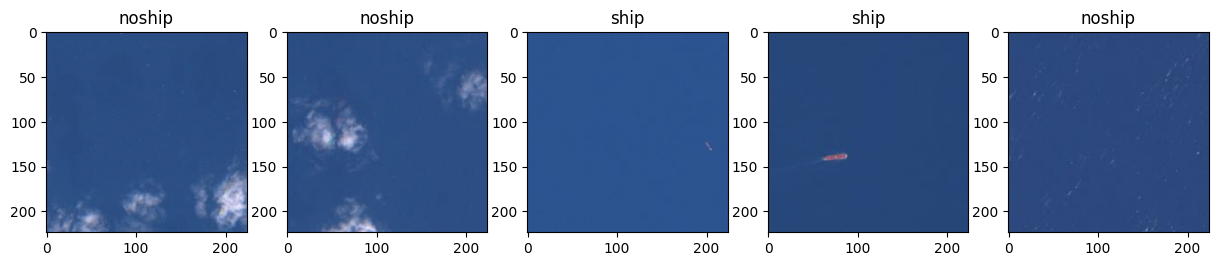

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5)) 

for i in range(5):
    img, label = dataset[i]
    label = class_map[label]

    axs[i].imshow(img)
    axs[i].set_title(label)

# Models
- https://pytorch.org/vision/stable/models.html
- https://pytorch.org/vision/main/models
- load your neural netwrok for feature extraction


To Do
- Use fine-tuned AiTlas

In [24]:
all_models = models.list_models()
# classification_models = models.list_models(module=models)
all_models

In [15]:
weights = ['IMAGENET1K_V1', 'IMAGENET1K_V2', 'IMAGENET1K_SWAG_E2E_V1', 'IMAGENET1K_SWAG_E2E_V1', 'IMAGENET1K_SWAG_LINEAR_V1']

In [27]:
model = torch.hub.load("pytorch/vision", 'resnet50', weights="IMAGENET1K_V2")

Using cache found in /home/amir/.cache/torch/hub/pytorch_vision_main


### Swin

In [6]:
# Swin
from torchvision.models import swin_v2_b, Swin_B_Weights

model = models.swin_v2_b(weights=Swin_B_Weights).to(device).eval()

total_params = '{:,}'.format(sum(p.numel() for p in model.parameters()))
total_params

'87,930,848'

In [ ]:
model

### ResNet

In [60]:
# ResNet

from torchvision.models import resnet50, ResNet50_Weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device).eval()
# model = models.resnet50(pretrained=True)




num_classes = 17
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
checkpoint = torch.load('resnet.pth', map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)
model.to(device).eval()


total_params = '{:,}'.format(sum(p.numel() for p in model.parameters()))
total_params

'23,542,865'

In [58]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### RegNet

In [8]:
# RegNet

model = models.regnet_y_400mf(pretrained=True).to(device).eval()

total_params = '{:,}'.format(sum(p.numel() for p in model.parameters()))
total_params

/home/amir/miniconda3/envs/faiss/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amir/miniconda3/envs/faiss/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'4,344,144'

In [10]:
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

# Metrics

To Do
- What metrics for CBIR?

In [11]:
def accuracy(query_label, neighbors, labels):
    # ~ precision in this case
    t, f = 0, 0
    for i in neighbors:
        if query_label == labels[i]:
            t += 1
        else:
            f += 1
    return '{:.1%}'.format(t / (t + f))

# Vector Database
- Store features in the VD
- I use FAISS

In [61]:
features = []
image_paths = []
labels = []
for x, y, img_path in dataset:
    img = x.permute(2, 0, 1).unsqueeze(0)
    
    with torch.no_grad():
        feature = model(img.to(device)).detach().cpu().numpy()

    features.append(feature)
    image_paths.append(img_path)
    labels.append(y)


features = np.concatenate(features, axis=0)

**Swin**
- took


**ResNet**  
- Took 3m 20s for AID on NVIDIA 300

### NN Search

In [234]:
id = random.randint(0, len(dataset))
img, label, img_path = dataset[id]
img = img.permute(2, 0, 1).unsqueeze(0)

query_image_path = img_path
query_label = label

with torch.no_grad():
    query_feature = model(img.to(device)).detach().cpu().numpy()

In [241]:
k = 20

neigh = NearestNeighbors(n_neighbors=k, algorithm='brute')
neigh.fit(features)
distances, indices = neigh.kneighbors(query_feature)

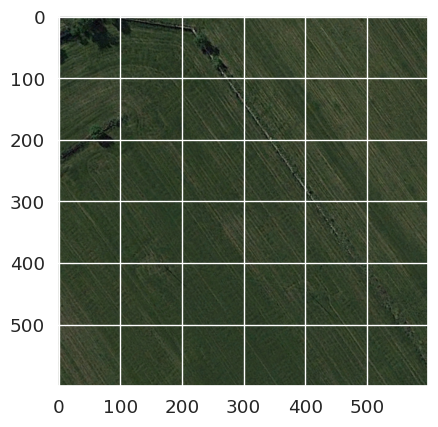

In [243]:
plt.imshow(query_image)

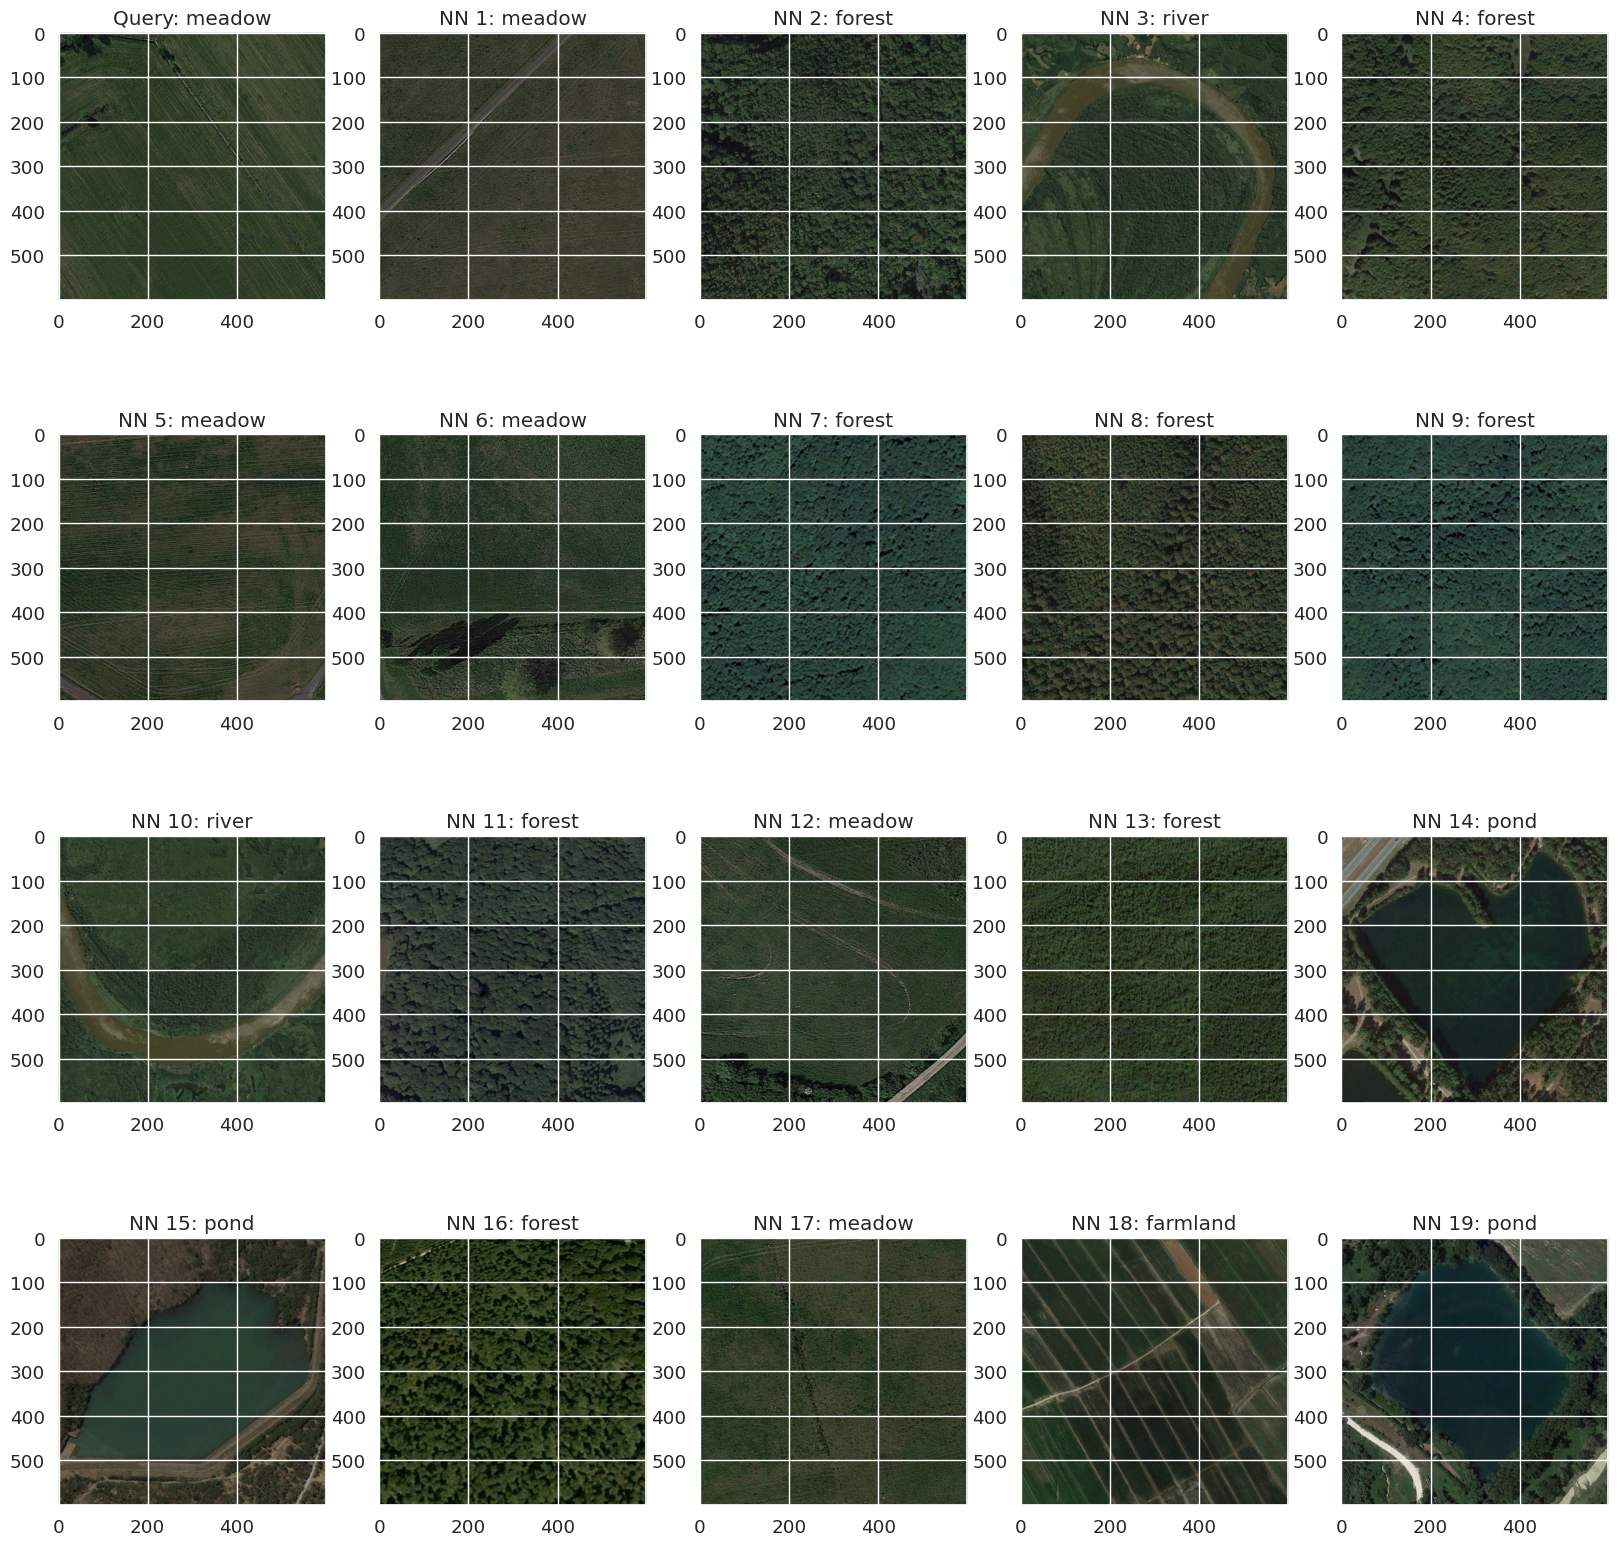

In [242]:
# Plot query image
query_image = Image.open(query_image_path)

rows, columns = 4, 5
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))


n = 0
for i in range(rows):
    for j in range(columns):
        if (i == 0) and (j == 0):
            axs[0][0].imshow(query_image)
            axs[0][0].set_title(f'Query: {class_map[query_label]}')
        else:
            axs[i][j].imshow(Image.open(image_paths[indices[0][n+1]]))
            axs[i][j].set_title(f'NN {n+1}: {class_map[labels[indices[0][n+1]]]}')
            n += 1

# Evaluation

In [221]:
def compute_confusion_matrix_and_accuracy(dataset, model, device, features, labels, ks):
    # Initialize a dictionary to hold confusion matrices and accuracies for different k
    results = {k: {'confusion_matrix': None, 'accuracy': None, 'per_class_accuracy': None, 'confusion_matrix_accuracy': None} for k in ks}
    
    # Initialize the NearestNeighbors model
    neigh = NearestNeighbors(n_neighbors=max(ks), algorithm='brute')
    neigh.fit(features)
    
    # Prepare ground truth and predicted labels for confusion matrix calculation
    all_true_labels = []
    all_pred_labels = {k: [] for k in ks}
    
    for i in range(len(dataset)):
        img, label, img_path = dataset[i]
        img = img.permute(2, 0, 1).unsqueeze(0)

        with torch.no_grad():
            query_feature = model(img.to(device)).detach().cpu().numpy()

        distances, indices = neigh.kneighbors(query_feature)
        
        true_label = labels[i]
        all_true_labels.append(true_label)
        
        for k in ks:
            neighbors = indices[0][:k]
            predicted_label = np.bincount([labels[n] for n in neighbors]).argmax()
            all_pred_labels[k].append(predicted_label)
    
    # Calculate confusion matrices and accuracies for each k
    for k in ks:
        cm = confusion_matrix(all_true_labels, all_pred_labels[k])
        acc = accuracy_score(all_true_labels, all_pred_labels[k])

        results[k]['confusion_matrix'] = cm
        results[k]['accuracy'] = acc
        # results[k]['per_class_accuracy'] = cm.diagonal() / cm.sum(axis=0)

        conf_mat_acc = np.zeros_like(cm, dtype=float)
        # results[k]['confusion_matrix'].dtype = float
        for i, row in enumerate(cm):
            conf_mat_acc[i] = row / row.sum()
        results[k]['confusion_matrix_accuracy'] = conf_mat_acc
    

    
    return results

In [229]:
ks = [10, 50, 100]
results = compute_confusion_matrix_and_accuracy(dataset, model, device, features, labels, ks)

In [230]:
results

{10: {'confusion_matrix': array([[202,  11,   7,   1,  17,   6,   0,   5,   2,   2,   0,  16,  16,
            2,  20,  10,   5,   0,   7,  15,  21,   5,  13,   5,   5,   2,
            5,   5,   2,  13],
         [ 34,  92,   7,   5,  23,   0,   0,   0,   3,   3,   0,   4,  16,
            1,   3,   7,   3,   0,   3,  17,   9,   3,   3,   2,  10,   1,
            3,   1,   1,   6],
         [ 22,   4, 105,   5,  20,   3,   0,   2,   8,   6,   0,   1,   3,
            0,   1,   2,  13,   0,   0,  16,   5,   5,  19,   3,   4,   4,
            1,   3,   1,   4],
         [ 13,   4,   2, 194,   6,  10,  10,   6,  13,   2,   1,  13,   1,
            8,  32,  14,   2,  14,   2,   4,   0,   0,   5,   5,   0,   1,
            8,   0,   0,   0],
         [ 28,  12,  27,   6, 164,   2,   0,   0,   5,   4,   0,   2,  21,
            6,   5,   0,  21,   0,   9,  20,   6,   5,  16,   0,  22,   1,
            1,   4,   1,   2],
         [  7,   0,   3,   8,   3, 124,   0,   4,   1,   0,   0,   7,  

In [231]:
def visualize_confusion_matrix(cm, class_names, k):
    plt.figure(figsize=(20, 20))  # Increase figure size
    sns.set(font_scale=1.2)  # Increase font scale
    sns.heatmap(cm, annot=True, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12, "ha": 'center', "va": 'center'}, linewidths=.5, linecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Accuracies for k={k}')
    plt.show()

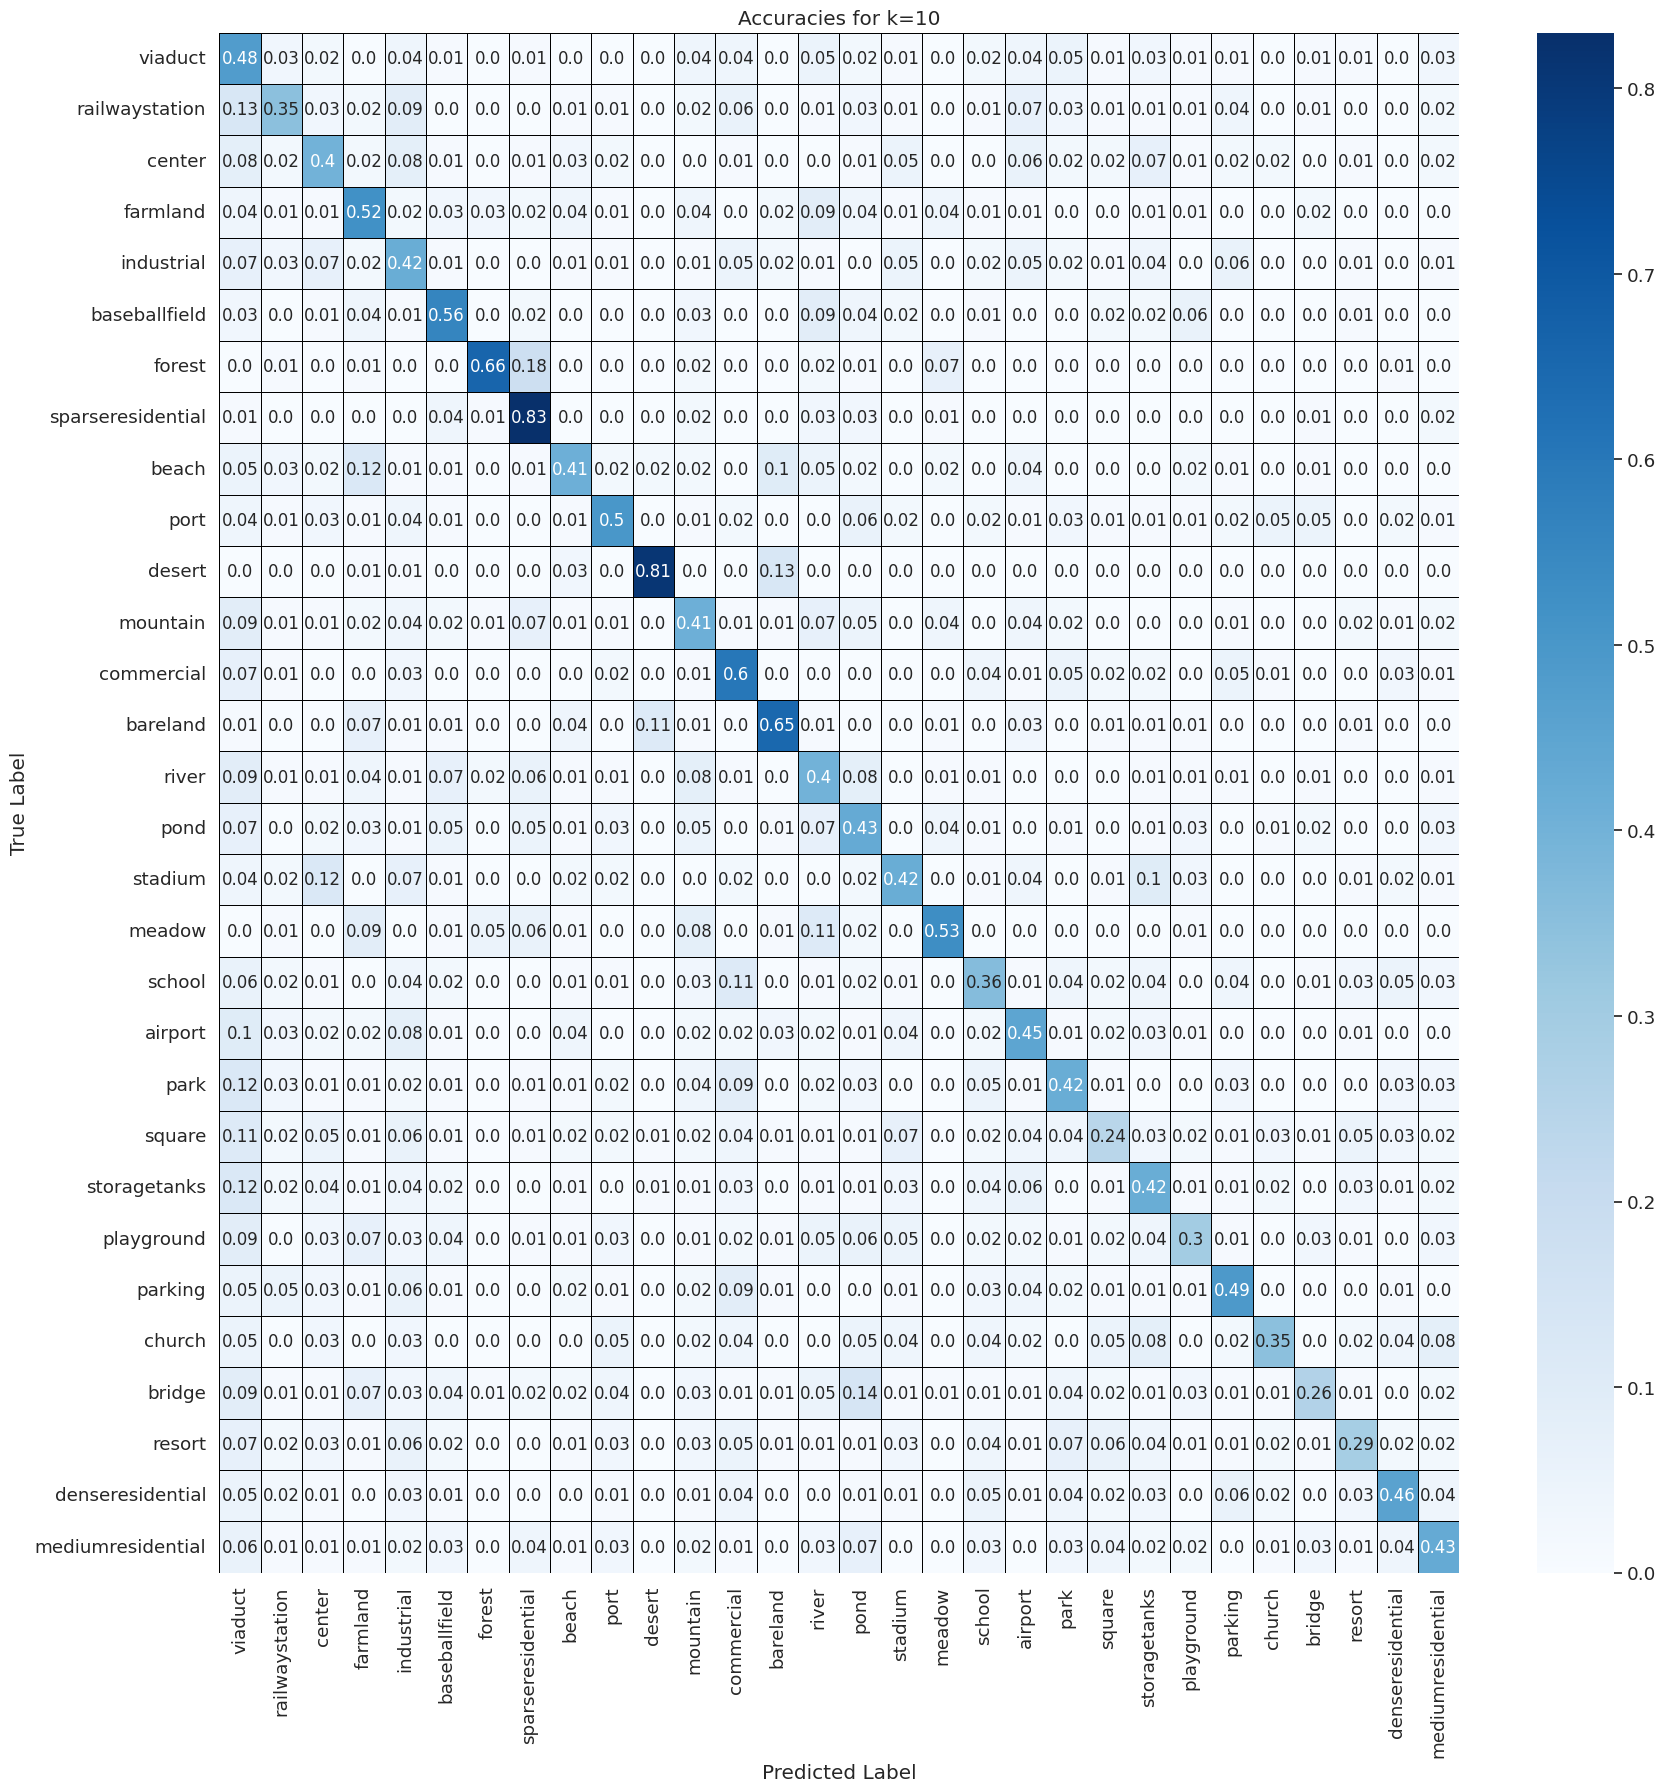

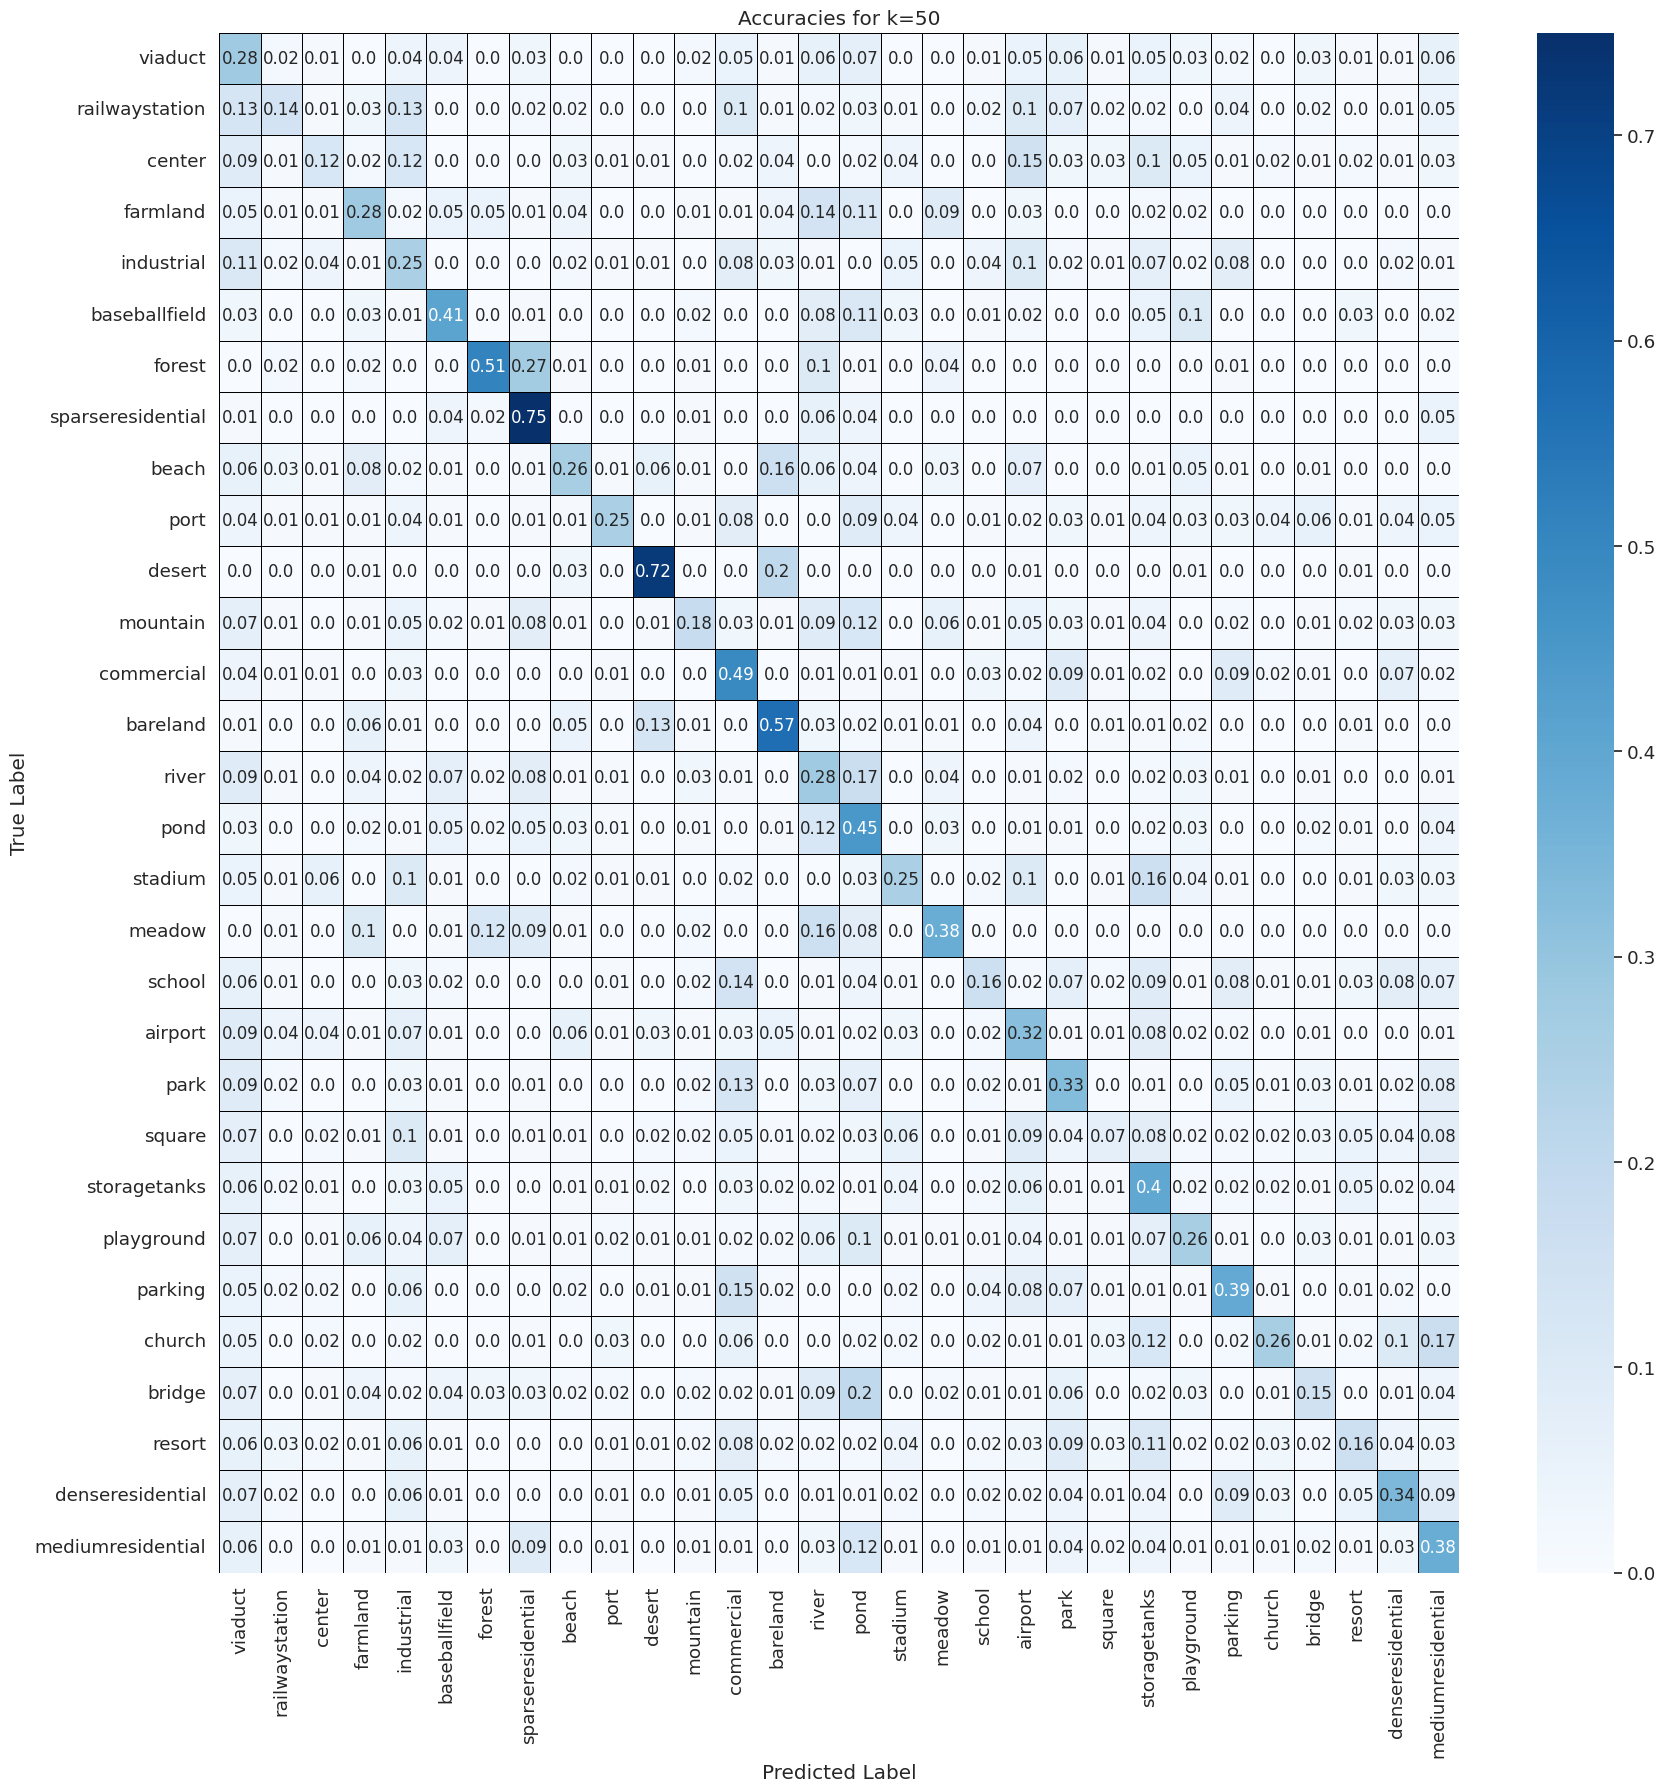

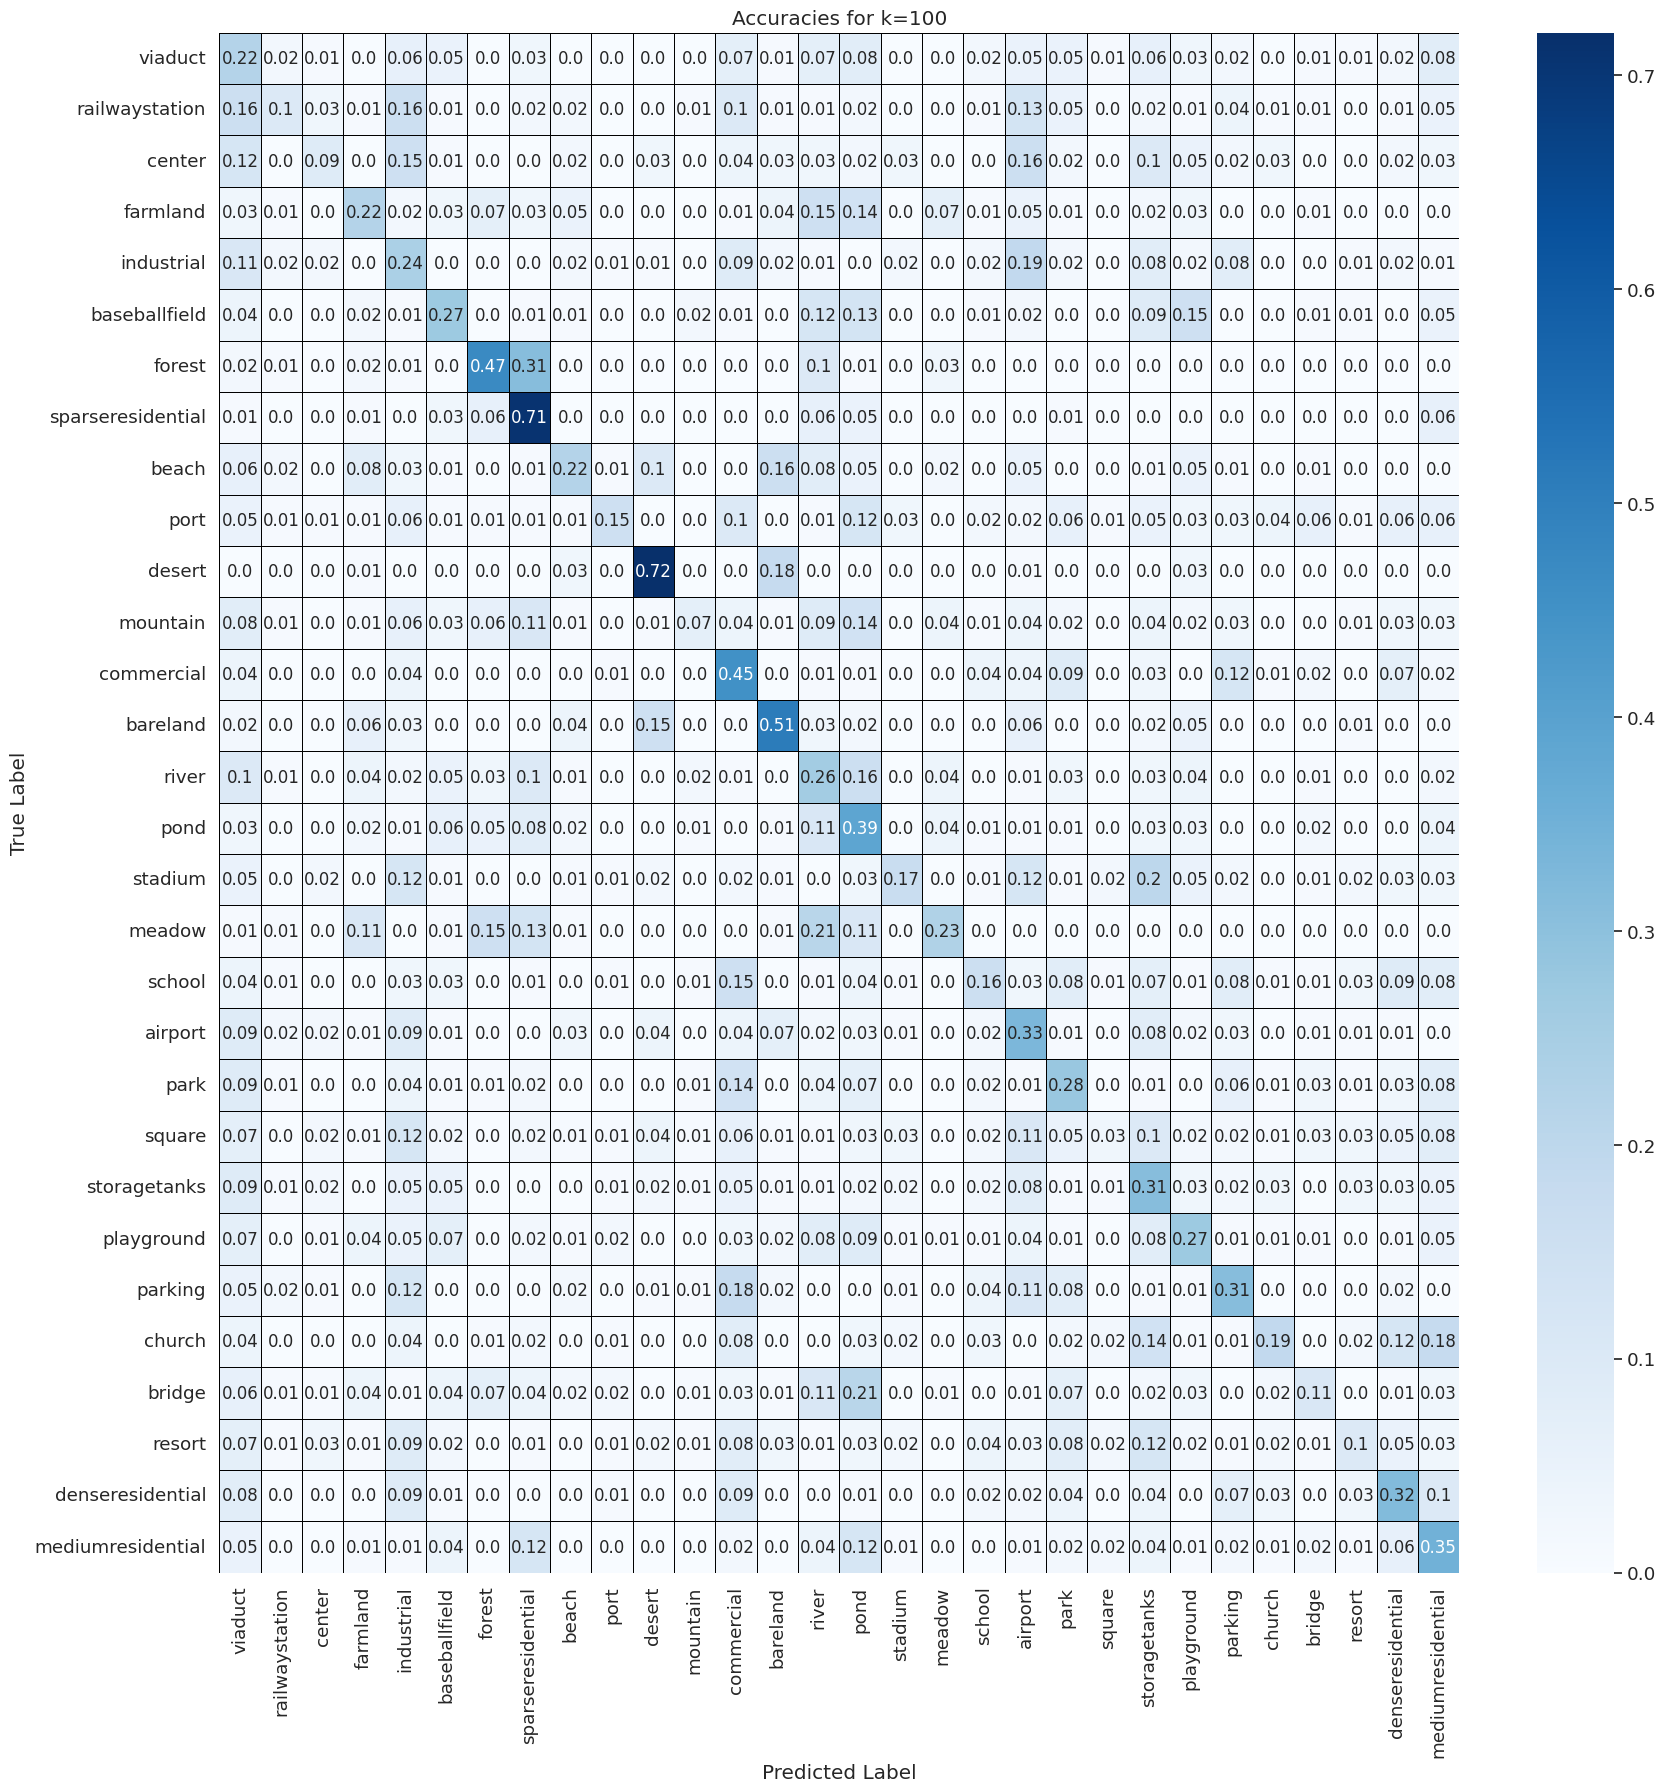

In [232]:
for k in ks:
    visualize_confusion_matrix(np.round(results[k]['confusion_matrix_accuracy'],2), classes, k)

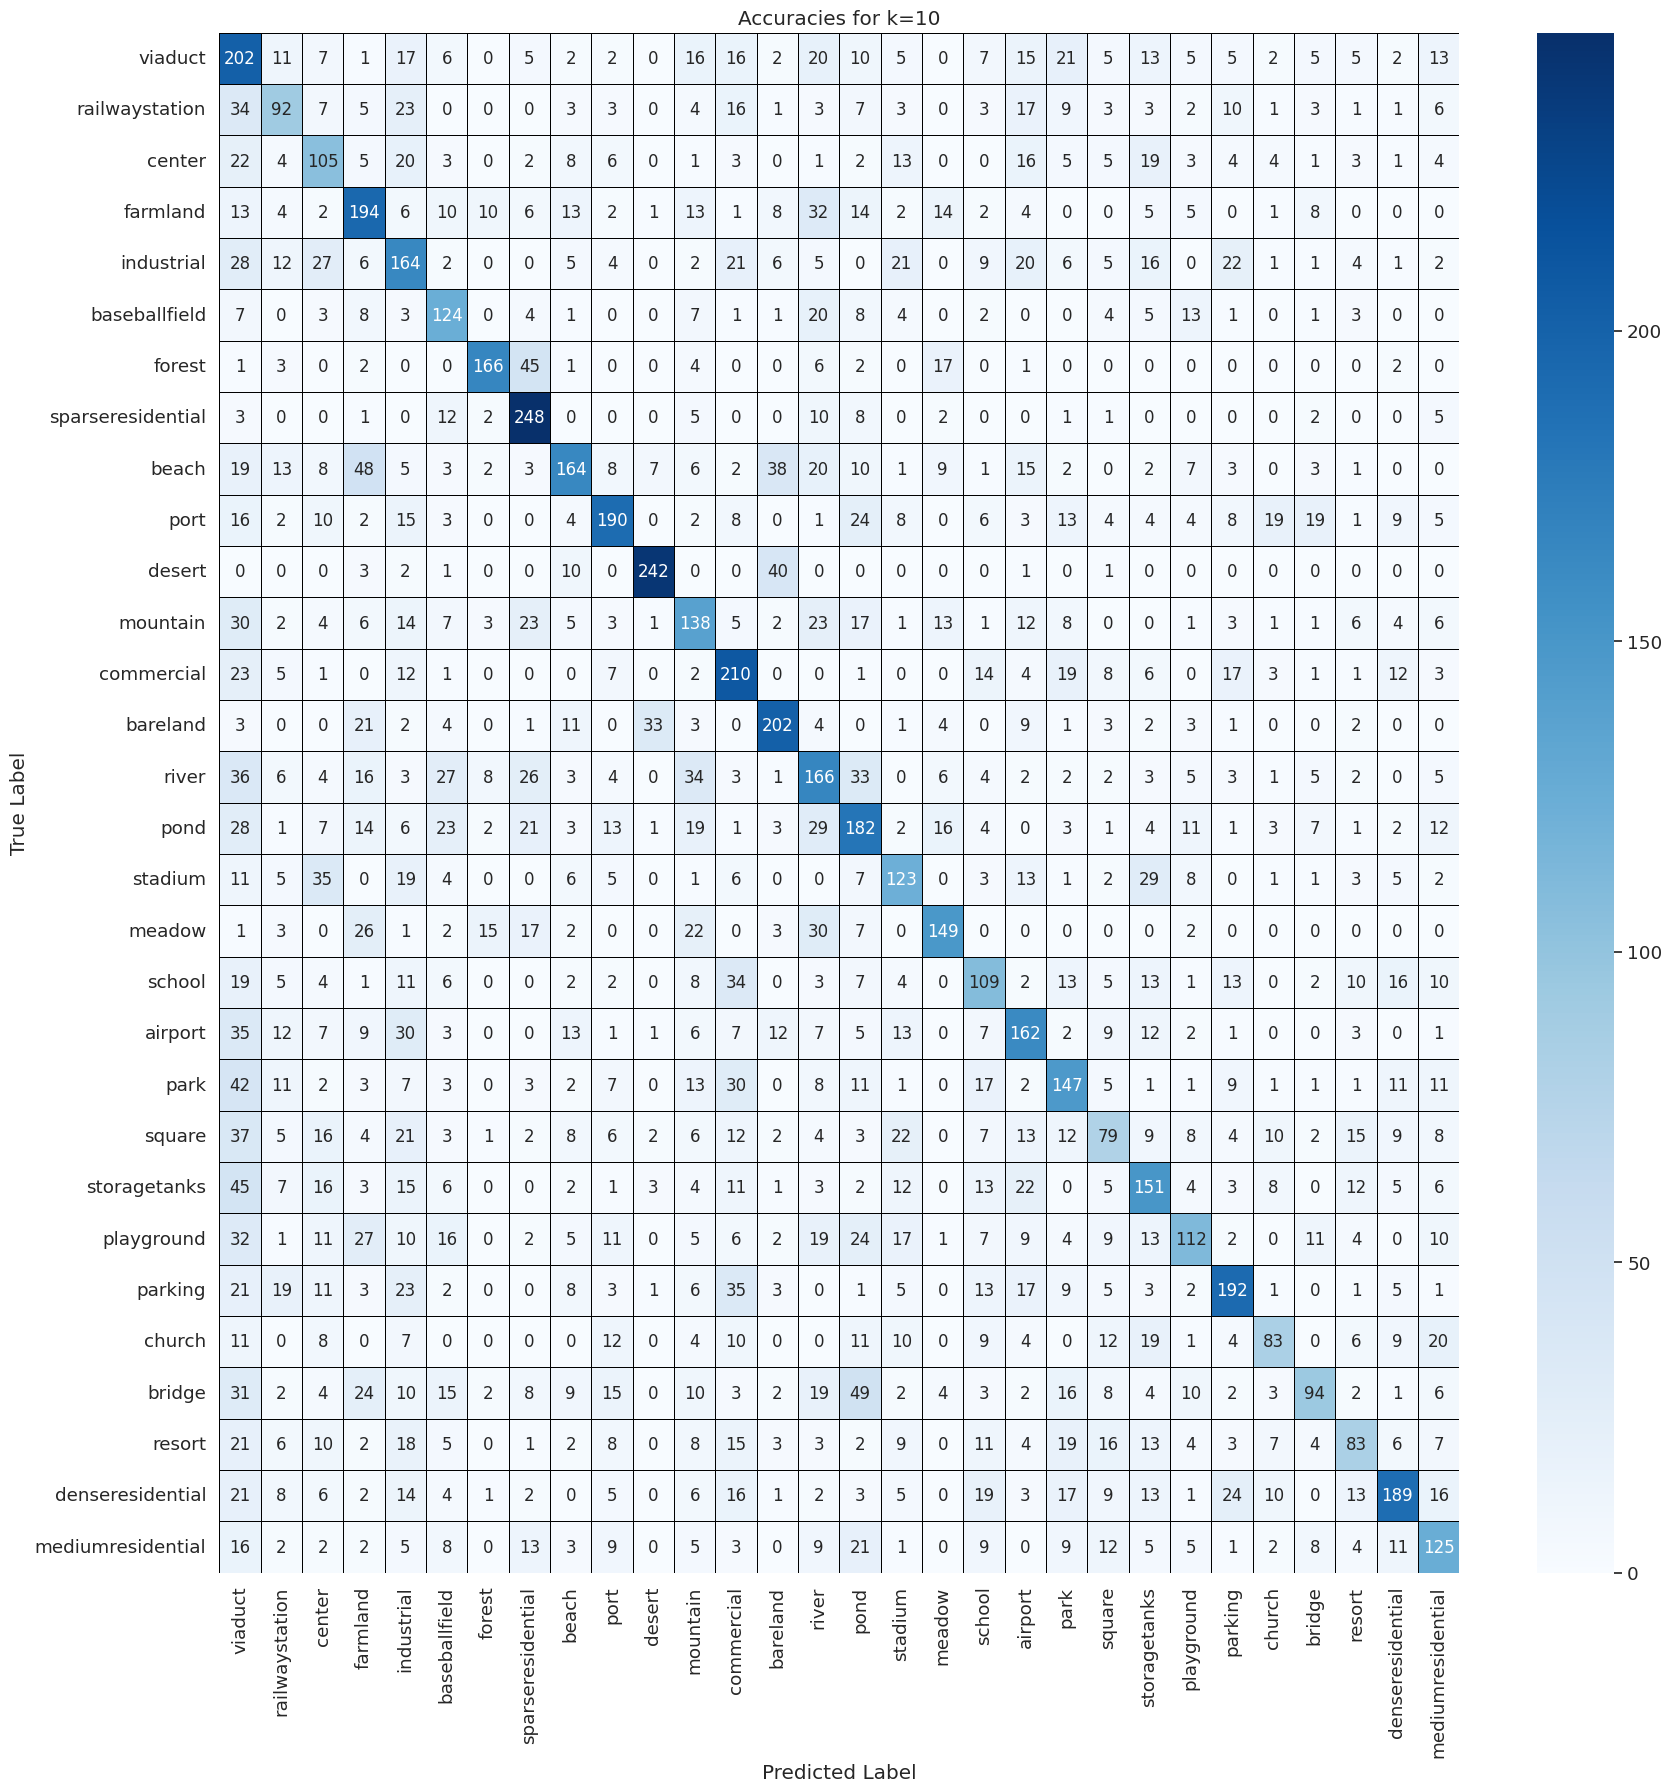

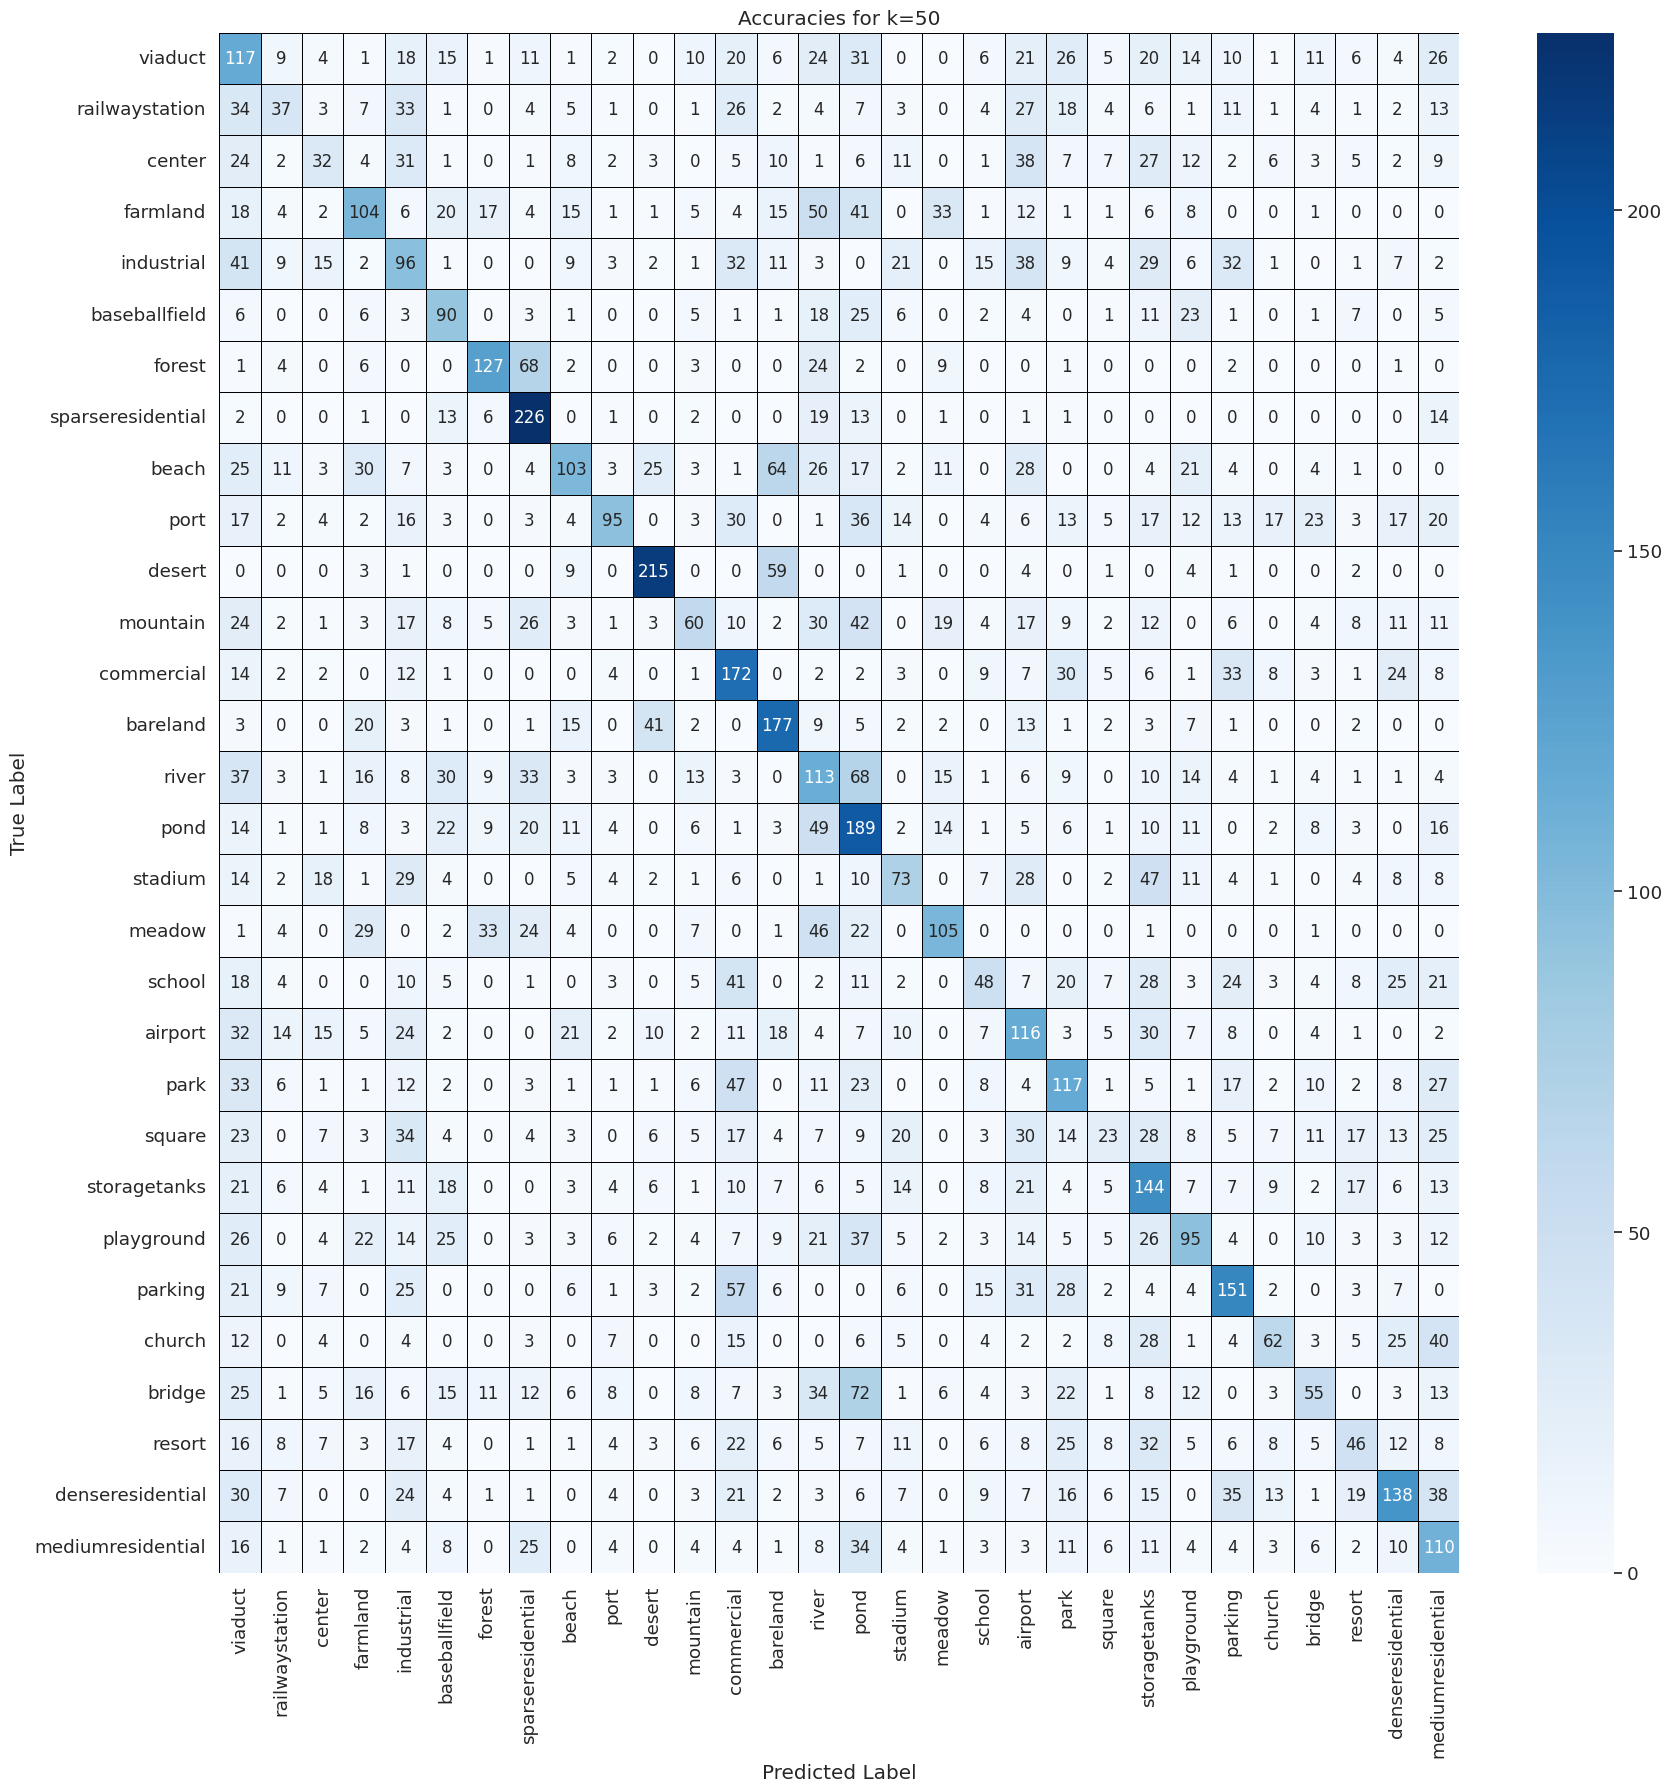

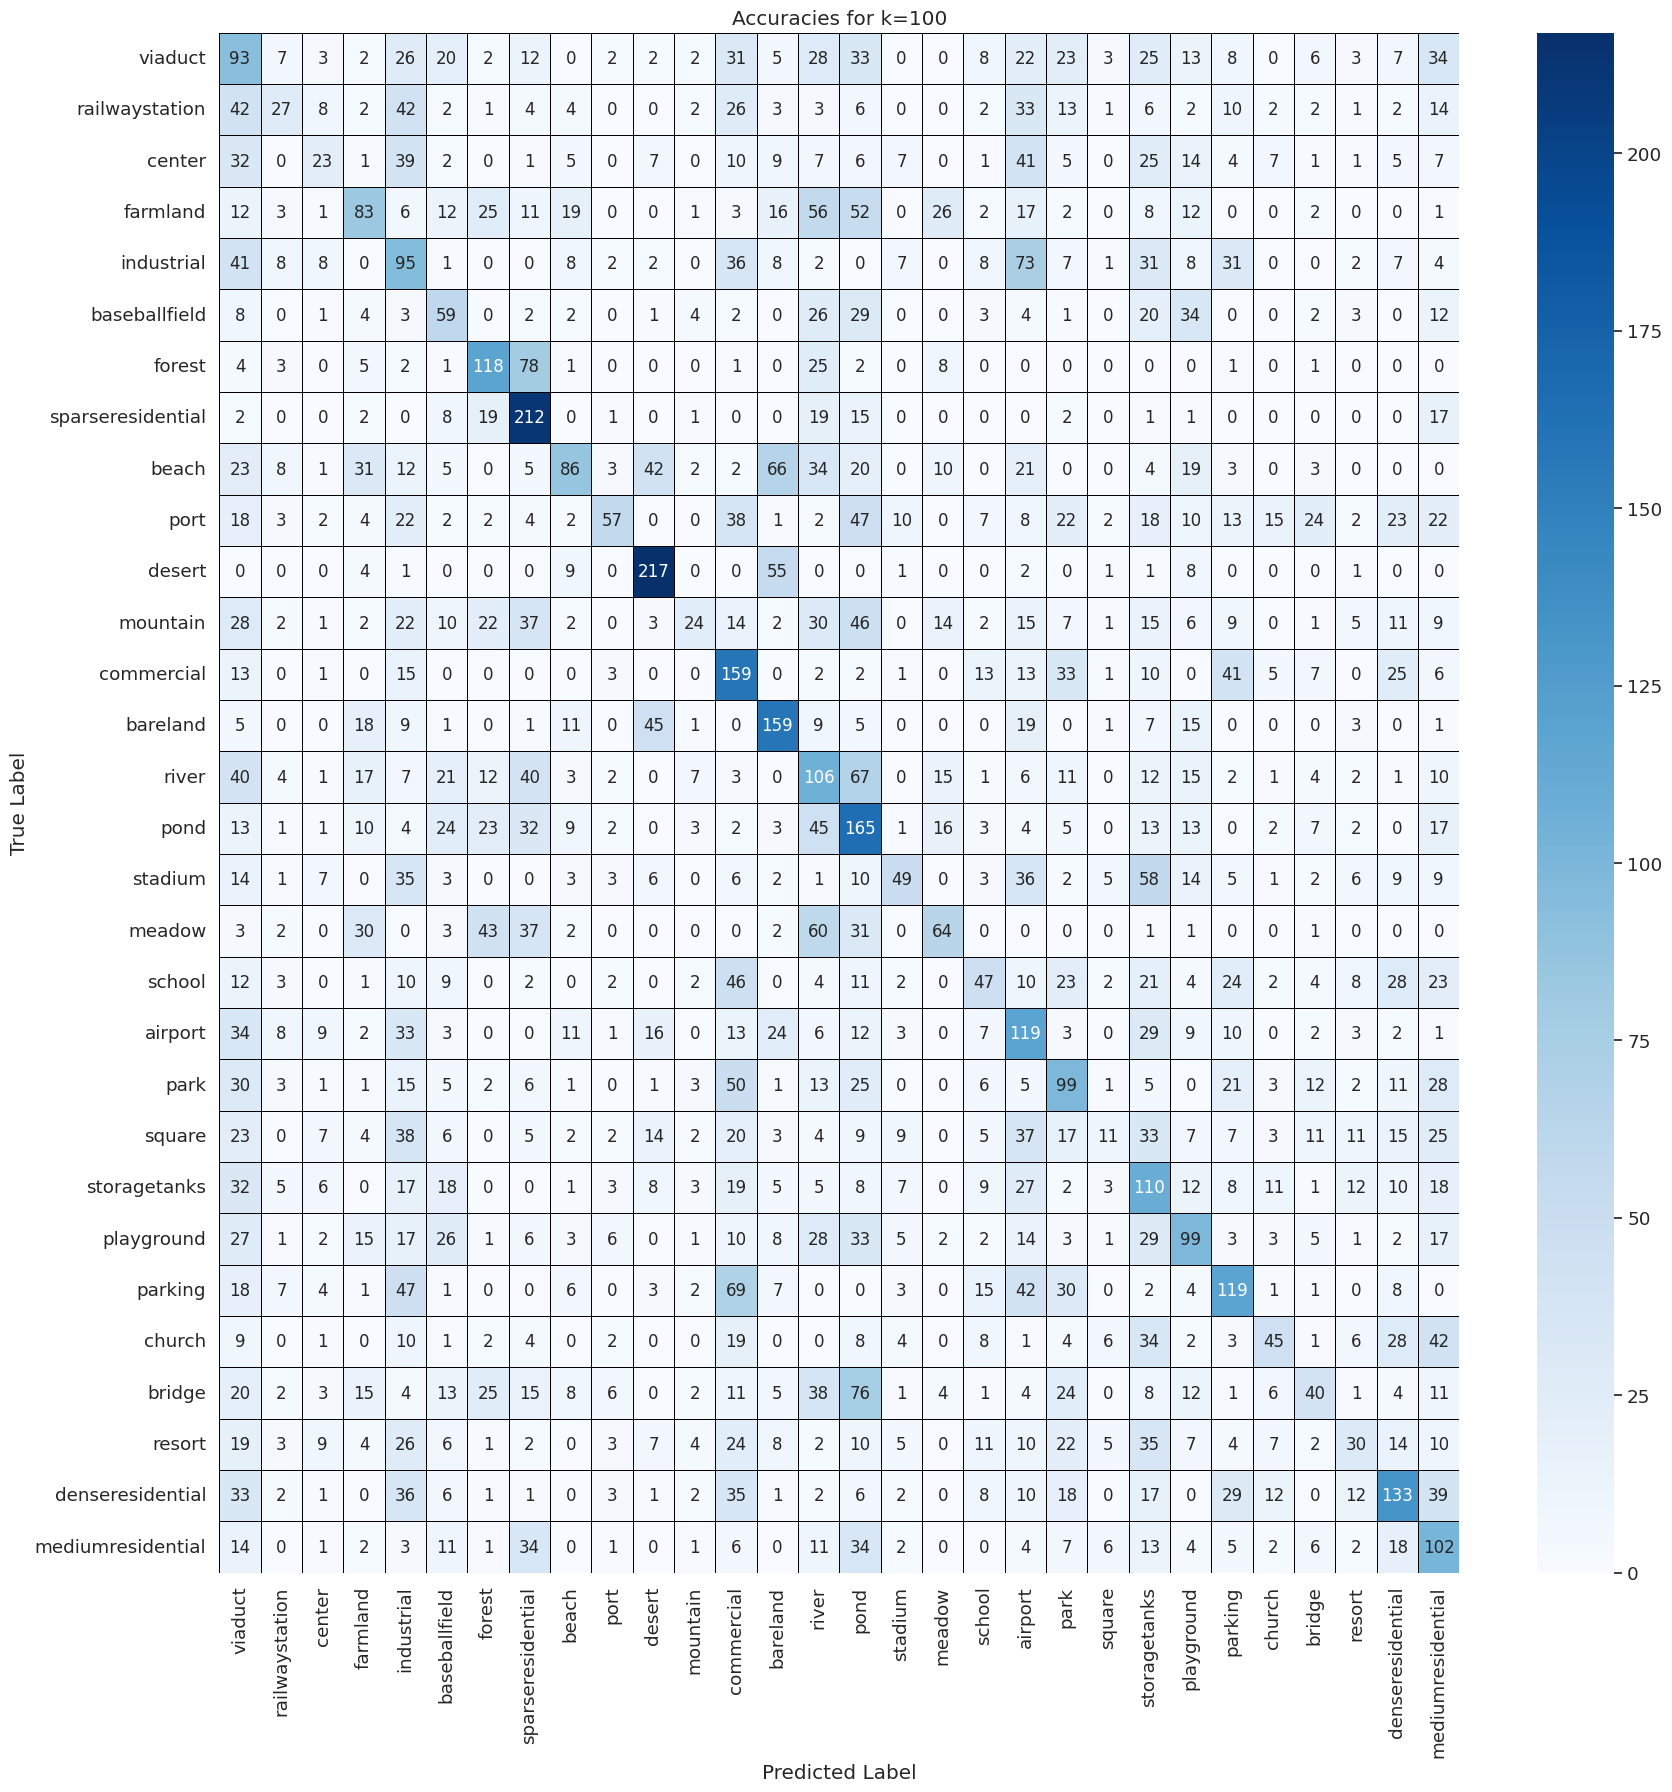

In [233]:
for k in ks:
    visualize_confusion_matrix(results[k]['confusion_matrix'], classes, k)